In [1]:
!pip install ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 MB 31.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import zipfile
import gdown
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image, ImageFile
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from torchvision import datasets, transforms
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from ray import tune, train
import ray
from ray.tune.schedulers import ASHAScheduler
from ray.tune import CLIReporter

In [3]:
from google.colab import drive

# This will prompt you to authorize access to your Google Drive
drive.mount('/content/drive')
# Change the working directory to a folder in your Google Drive
os.chdir('/content/drive/MyDrive/Colab Notebooks/CombinedImages')

# Confirm the working directory has been changed
print("Current Working Directory: ", os.getcwd())

Mounted at /content/drive
Current Working Directory:  /content/drive/MyDrive/Colab Notebooks/CombinedImages


In [4]:
!ls

Data  Final_VGGNet.ipynb  Final_VGGNet_ray_tuner.ipynb


## Load Dataset: Unable to Download Due to Restrictions/Error

# Load and Display Images (Loading dataset from Google Drive)




In [5]:
# import re
# def sanitize_filename(filename):
#     # Replace spaces with underscores and remove special characters
#     return re.sub(r'[^\w\-_\. ]', '_', filename)

# def rename_files_in_directory(directory):
#     index = 1  # Start the index from 1
#     for root, _, files in os.walk(directory):
#         for file in files:
#             file_extension = os.path.splitext(file)[1]  # Get the file extension (e.g., .jpg, .png)
#             new_name = f"image{index}{file_extension}"
#             old_path = os.path.join(root, file)
#             new_path = os.path.join(root, new_name)

#             # Print old and new paths for debugging
#             print(f"Attempting to rename: '{old_path}' to '{new_path}'")

#             # Ensure that the new file name does not conflict with an existing file
#             if not os.path.exists(new_path):
#                 try:
#                     os.rename(old_path, new_path)
#                     print(f"Renamed {old_path} to {new_path}")
#                     index += 1  # Increment the index for the next file
#                 except Exception as e:
#                     print(f"Failed to rename {old_path}: {e}")
#             else:
#                 print(f"File {new_path} already exists. Skipping {old_path}.")

# # Run the renaming script on your dataset directory
# rename_files_in_directory('Data/')

In [6]:
def remove_corrupted_images(directory):
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)

        # Only process image files (you can add more extensions if needed)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
            try:
                # Attempt to open the image
                with Image.open(file_path) as img:
                    img.verify()  # Verify the image integrity
            except (OSError, Image.DecompressionBombError):
                # If the image is corrupted, remove it
                print(f"Removing corrupted image: {file_path}")
                os.remove(file_path)

In [7]:
directory = '/content/drive/MyDrive/Colab Notebooks/CombinedImages/Data'

# Remove corrupted images
remove_corrupted_images(directory)

In [8]:
!chmod -R 755 Data/

In [9]:
# Define the root directory of the dataset
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

data_dir = '/content/drive/MyDrive/Colab Notebooks/CombinedImages/Data'

from PIL import Image, UnidentifiedImageError

class CustomImageFolder(datasets.ImageFolder):
    def __getitem__(self, idx):
        path, target = self.samples[idx]
        try:
            sample = Image.open(path).convert('RGB')
        except (UnidentifiedImageError, OSError) as e:
            print(f"Skipping corrupted image: {path}")
            return None, None  # Return None values to indicate a skip

        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

# Define transformations to apply to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a standard size
    transforms.ToTensor(),          # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet means and std
])

#dataset = CustomImageFolder(root=data_dir, transform=transform)

# Filter out None values in DataLoader
def custom_collate(batch):
    batch = list(filter(lambda x: x[0] is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)


# Load the dataset from the directory
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
sample = dataset[0]
print(sample)



# Define the proportions for train, val, and test
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # 15% for testing

print(train_size, val_size, test_size)



(tensor([[[ 0.4679,  0.3138,  0.7077,  ...,  1.3242,  1.1187,  0.0912],
         [ 0.3823,  0.2967,  0.5193,  ...,  1.3070,  0.9988,  0.4851],
         [ 0.5364,  0.3823,  0.2111,  ...,  1.1872,  0.9132,  0.9303],
         ...,
         [ 0.2282,  0.2111,  0.3138,  ...,  1.4954,  1.1529,  1.0331],
         [ 0.5364,  0.3481,  0.2282,  ...,  1.3413,  1.0159,  0.9988],
         [ 0.6049,  0.5364,  0.3652,  ...,  0.9988,  0.9474,  0.8618]],

        [[-1.5105, -1.3704, -1.0203,  ...,  1.6583,  1.5882,  0.8354],
         [-1.3880, -1.4230, -1.2829,  ...,  1.6758,  1.4307,  1.2206],
         [-1.0028, -1.3354, -1.5455,  ...,  1.5882,  1.4657,  1.5532],
         ...,
         [ 1.2031,  1.1331,  1.1681,  ...,  0.1001,  0.1352,  1.0455],
         [ 1.0455,  0.9055,  1.0105,  ...,  0.1001,  0.5378,  1.5532],
         [ 1.0105,  0.9055,  0.9230,  ...,  0.0476,  1.0280,  1.5357]],

        [[-0.3927, -0.0964,  0.2522,  ...,  2.4134,  2.3786,  1.7685],
         [-0.3404, -0.4450, -0.3055,  ...,  

In [10]:
from torch.utils.data import DataLoader, random_split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create the dataloaders
def create_dataloader(loader_type):
  if loader_type=='train':
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,num_workers=0)
    print(f"len train_loader {len(train_loader)}")
    return train_loader
  elif loader_type=='val':
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False,num_workers=0)
    return val_loader
  else:
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False,num_workers=0)
    return test_loader



# Prepare Data for PyTorch

# Define VGGNet Model

In [11]:
# Define VGGNet model
class VGGNet(nn.Module):
    def __init__(self, num_classes=2):
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [12]:
# train_loader = create_dataloader(loader_type='train')
# val_loader = create_dataloader(loader_type='val')
# for batch_idx, (inputs, labels) in enumerate(train_loader):
#     # `inputs` is your batch of input data
#     # `labels` is the corresponding batch of labels
#     # `batch_idx` is the index of the current batch

#     # Example: Print the batch index and the shape of the inputs
#     print(f"Train Batch {batch_idx}: Inputs Shape: {inputs.shape}, Labels Shape: {labels.shape}")

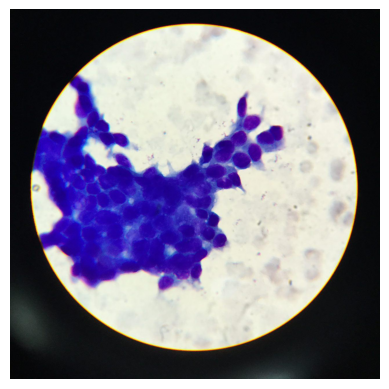

In [13]:
import os
path = 'Data/Malign/image831.jpg'
from PIL import Image
image = Image.open(path)
plt.imshow(image)
plt.axis('off')  # Turn off the axis labels
plt.show()


# Train and Test the model

In [18]:
from PIL import ImageFile
from ray import tune, train

def train_model(config):
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    TUNE_DISABLE_STRICT_METRIC_CHECKING = True
    model = VGGNet(num_classes=2)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=0.9 if config["optimizer"] == "SGD" else 0)

    train_loader = create_dataloader(loader_type='train')
    val_loader = create_dataloader(loader_type='val')

    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = val_correct / val_total

        # Correct use of tune.report
        train.report(dict(
            loss=train_loss,
            accuracy=train_accuracy,
            val_loss=val_loss,
            val_accuracy=val_accuracy
        ))






In [19]:
# Define the search space for hyperparameters
search_space = {
    "lr": tune.choice([1e-4, 1e-1]),
    "optimizer": tune.choice(["SGD"])
}

# Initialize Ray
#ray.init()

scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=10,
    grace_period=2,
    reduction_factor=2
)

# Ray Tune experiment setup
analysis = tune.run(
    train_model,
    config=search_space,
    resources_per_trial={"cpu": 2, "gpu": 1 if torch.cuda.is_available() else 0},
    num_samples=2,
    scheduler=scheduler,
    progress_reporter=tune.CLIReporter(
        metric_columns=["loss", "train_accuracy", "val_loss", "val_accuracy"]
    )
)

print("Best hyperparameters found were: ", analysis.best_config)


2024-09-22 07:53:33,085	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2024-09-22 07:53:33,087	WARNING tune.py:902 -- AIR_VERBOSITY is set, ignoring passed-in ProgressReporter for now.


+--------------------------------------------------------------------+
| Configuration for experiment     train_model_2024-09-22_07-53-33   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 2                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_2024-09-22_07-53-33

Trial status: 2 PENDING
Current time: 2024-09-22 07:53:33. Total running time: 0s
Logical resource usage: 2.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------+
| Trial name                status         lr   optimizer   |
+-----------------------------------------------------------+
| train_model_c3c8f_00000   PENDING    0.0001   SGD         |
| train_model_c3

2024-09-22 08:19:18,068	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_2024-09-22_07-53-33' in 0.0043s.



Trial train_model_c3c8f_00001 finished iteration 10 at 2024-09-22 08:19:18. Total running time: 25min 44s
+--------------------------------------------------+
| Trial train_model_c3c8f_00001 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         75.5267 |
| time_total_s                              759.74 |
| training_iteration                            10 |
| accuracy                                 0.57641 |
| loss                                     0.68144 |
| val_accuracy                             0.57367 |
| val_loss                                 0.68235 |
+--------------------------------------------------+

Trial train_model_c3c8f_00001 completed after 10 iterations at 2024-09-22 08:19:18. Total running time: 25min 44s

Trial status: 2 TERMINATED
Current time: 2024-09-22 08:19:18. Total running time: 25min 44s
Logical resource usage: 2.0/8 CPUs, 1.0/1 GPUs (0

ValueError: To fetch the `best_config`, pass a `metric` and `mode` parameter to `tune.run()`. Alternatively, use the `get_best_config(metric, mode)` method to set the metric and mode explicitly.

In [22]:
analysis.get_best_config(metric="loss", mode="min")

{'lr': 0.0001, 'optimizer': 'SGD'}